In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)
  plt.show()


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("./LiberationSansNarrow-Regular.ttf",
                              30)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

  return result

2.16.1
The following GPU devices are available: 


In [2]:
downloaded_image_path = "./IMG_5474.JPG"

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


W0000 00:00:1717004258.381100 1950312 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -2484 } dim { size: -2485 } dim { size: -2486 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -105 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -105 } dim { size: 17 } dim { size: 17 } dim { size: 1088 } } }

Found 100 objects.
Inference time:  24.303375720977783


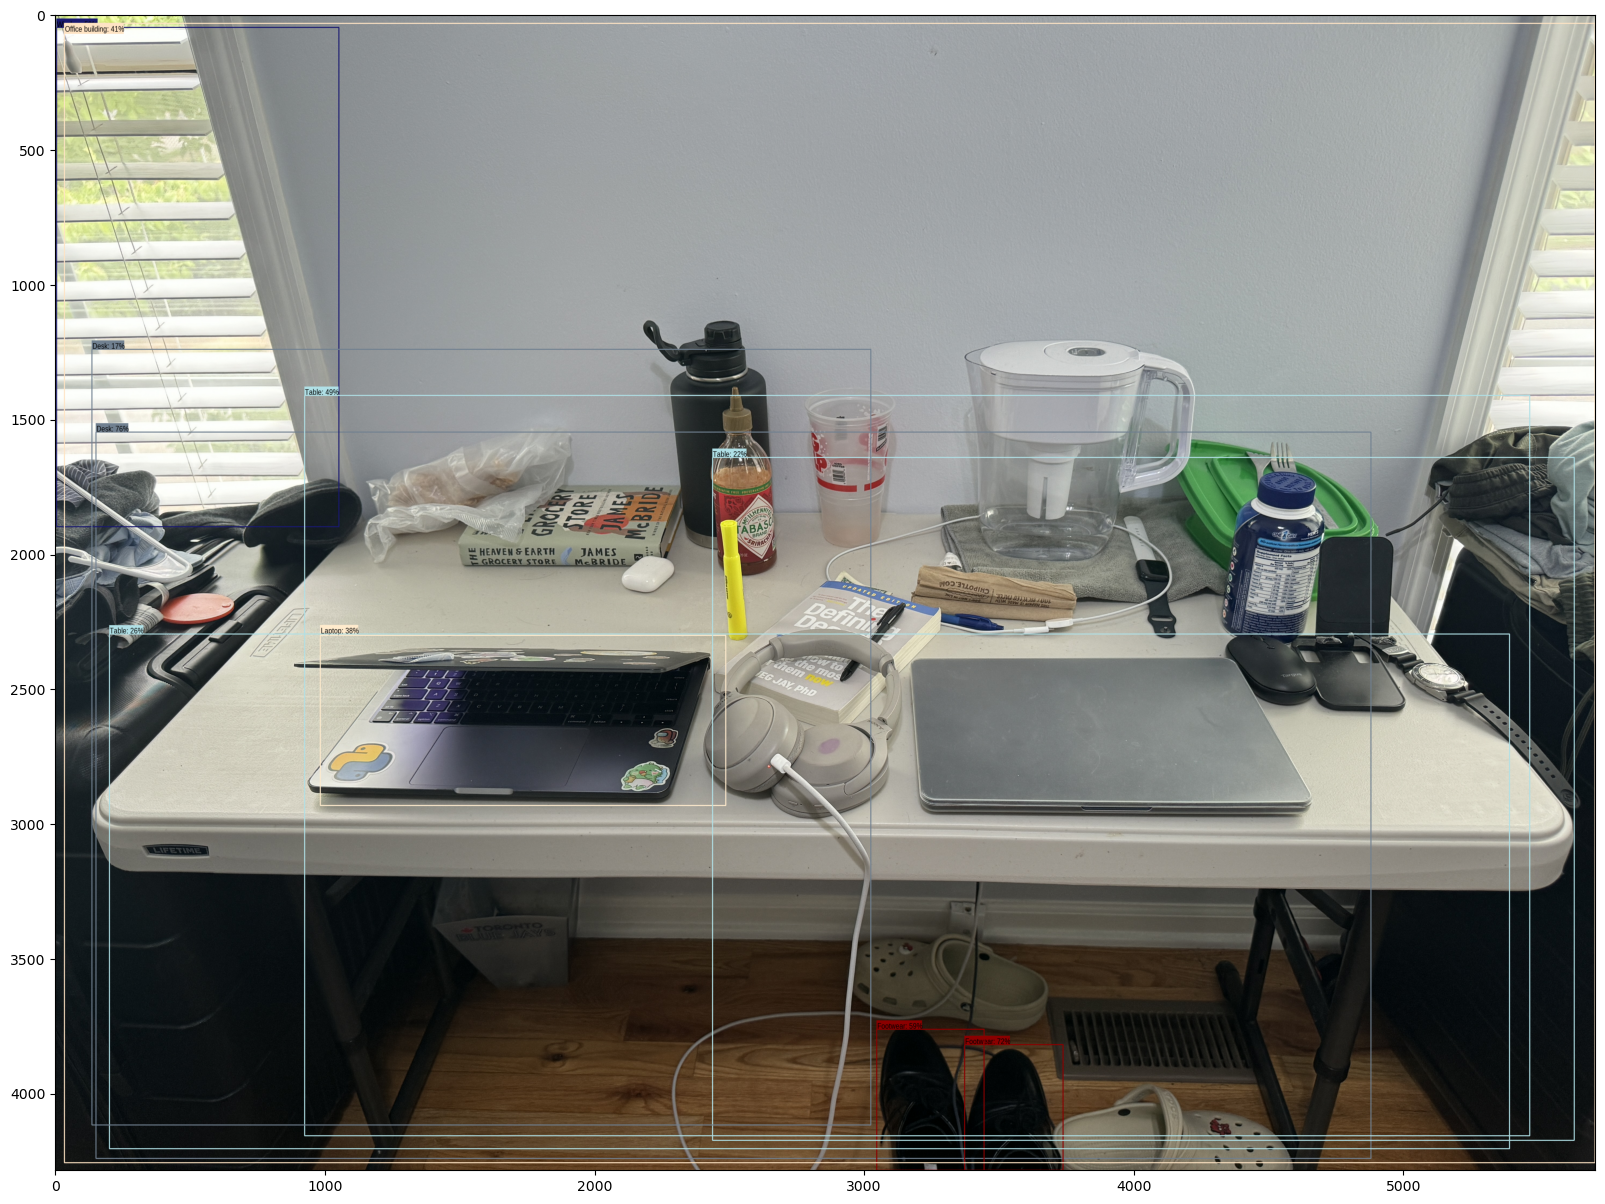

[b'Desk' b'Footwear' b'Window' b'Footwear' b'Table' b'Office building'
 b'Laptop' b'Table' b'Table' b'Desk' b'Desk' b'Kitchen appliance'
 b'Bottle' b'Blender' b'Coffeemaker' b'Food processor' b'Drink' b'Mixer'
 b'Home appliance' b'Footwear' b'Footwear' b'Tableware' b'Desk' b'Desk'
 b'Footwear' b'Table' b'Window' b'Table' b'Office building' b'Chair'
 b'Footwear' b'Footwear' b'Building' b'Blender' b'Desk' b'Auto part'
 b'Kitchen appliance' b'Kitchen appliance' b'Footwear' b'Footwear'
 b'Food processor' b'Home appliance' b'Computer keyboard' b'Table'
 b'Laptop' b'Kitchen appliance' b'Window' b'Toy' b'Window blind'
 b'Furniture' b'Office supplies' b'Window' b'House' b'Office building'
 b'Food' b'Kitchen appliance' b'Computer keyboard' b'Drink' b'Kettle'
 b'Furniture' b'Chair' b'Kitchen appliance' b'Bottle' b'Office supplies'
 b'Office supplies' b'Shelf' b'Chair' b'Furniture' b'Kitchen appliance'
 b'Furniture' b'Table' b'Tableware' b'Coffee table' b'Desk' b'Furniture'
 b'Furniture' b'Fashio

In [3]:
result = run_detector(detector, downloaded_image_path)

print(result['detection_class_entities'])

In [31]:
print(result['detection_class_entities'])

if b'Desk' in result['detection_class_entities'] or b'Table' in result['detection_class_entities'] :
    print(True)
else:
    print(False)

[b'Desk' b'Footwear' b'Window' b'Footwear' b'Table' b'Office building'
 b'Laptop' b'Table' b'Table' b'Desk' b'Desk' b'Kitchen appliance'
 b'Bottle' b'Blender' b'Coffeemaker' b'Food processor' b'Drink' b'Mixer'
 b'Home appliance' b'Footwear' b'Footwear' b'Tableware' b'Desk' b'Desk'
 b'Footwear' b'Table' b'Window' b'Table' b'Office building' b'Chair'
 b'Footwear' b'Footwear' b'Building' b'Blender' b'Desk' b'Auto part'
 b'Kitchen appliance' b'Kitchen appliance' b'Footwear' b'Footwear'
 b'Food processor' b'Home appliance' b'Computer keyboard' b'Table'
 b'Laptop' b'Kitchen appliance' b'Window' b'Toy' b'Window blind'
 b'Furniture' b'Office supplies' b'Window' b'House' b'Office building'
 b'Food' b'Kitchen appliance' b'Computer keyboard' b'Drink' b'Kettle'
 b'Furniture' b'Chair' b'Kitchen appliance' b'Bottle' b'Office supplies'
 b'Office supplies' b'Shelf' b'Chair' b'Furniture' b'Kitchen appliance'
 b'Furniture' b'Table' b'Tableware' b'Coffee table' b'Desk' b'Furniture'
 b'Furniture' b'Fashio